In [2]:
!python --version

Python 3.9.13


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb 26 19:55:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        Off  | 00000000:00:05.0 Off |                  N/A |
| 46%   29C    P8    11W / 120W |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%pip install torch
%pip install torchaudio
%pip install tensorflow
%pip install sklearn
%pip install datasets
%pip install optuna
%pip install pytorch-lightning
%pip install tqdm
%pip install transformers
%pip install requests
%pip install wandb
%pip install pyaudioconvert
%pip install sox
%pip install librosa

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=8c386200b6265a1964007cd5ad8a27fc0484723d25f3eeee48655db202c0ea7b
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 15.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
from collections import OrderedDict
import IPython.display as ipd
from sklearn.model_selection import GroupShuffleSplit
from datasets import load_dataset, load_metric
from transformers import AutoConfig, Wav2Vec2Processor
from dataclasses import dataclass
from typing import Optional, Tuple
from transformers.file_utils import ModelOutput
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import torch.nn.functional as F
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)
from dataclasses import dataclass
from typing import Dict, List, Optional, Union

import transformers
from transformers import Wav2Vec2Processor
from transformers import EvalPrediction
from transformers import TrainingArguments
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)
import optuna
from optuna.trial import TrialState
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import librosa

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys
import glob


#if is_apex_available():
  # from apex import amp

In [6]:
speaker_independet_scenario = True
eval_steps = 10
logging_steps = 10
per_device_train_batch_size= 8
per_device_eval_batch_size= 8
batch_size = 8
num_proc = 1
save_steps = eval_steps * 10    
model_output_dir="wav2vec2-xlsr-model-output"
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
#model_name_or_path = "facebook/wav2vec2-large-xlsr-53-italian"
#model_name_or_path = "facebook/wav2vec2-base-10k-voxpopuli-ft-it"
pooling_mode = "mean"
model_path = "ravdess-model-trained"
csv_save_path="data/csv_files"

In [7]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1
%env WANDB_DISABLED=true

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1
env: WANDB_DISABLED=true


In [8]:
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [9]:
data = []

for file in glob.glob("data/Actor_*/*.wav"):
  # get the base name of the audio file
  basename = os.path.basename(file)
  # get the emotion label
  emotion_code = basename.split("-")[2]
  if (emotion_code != '02'):
      emotion = int2emotion[emotion_code]
      # print(basename, emotion, file)

      # exclude emotion 'calm' to align with TESS

      try:
        # There are some broken files
        # s = torchaudio.load(os.path.abspath(file))
        data.append({
            "name": basename,
            "path": os.path.abspath(file),
            "emotion": emotion
        })
      except Exception as e:
        print(str(file), e)
        pass

In [11]:
data_test = []

for file in glob.glob("data/test/Actor_*/*.wav"):
  # get the base name of the audio file
  basename = os.path.basename(file)
  # get the emotion label
  emotion_code = basename.split("-")[2]
  if (emotion_code != '02'):
      emotion = int2emotion[emotion_code]
      # print(basename, emotion, file)

      try:
        # There are some broken files
        # s = torchaudio.load(os.path.abspath(file))
        data_test.append({
            "name": basename,
            "path": os.path.abspath(file),
            "emotion": emotion
        })
      except Exception as e:
        print(str(file), e)
        pass

In [12]:
import random

random.shuffle(data)

df = pd.DataFrame(data)
df.head()

name  \
0  03-01-06-02-01-02-13.wav   
1  03-01-06-02-01-02-05.wav   
2  03-01-06-02-01-01-18.wav   
3  03-01-08-01-01-01-11.wav   
4  03-01-05-01-02-01-14.wav   

                                                path    emotion  
0  /notebooks/data/Actor_13/03-01-06-02-01-02-13.wav    fearful  
1  /notebooks/data/Actor_05/03-01-06-02-01-02-05.wav    fearful  
2  /notebooks/data/Actor_18/03-01-06-02-01-01-18.wav    fearful  
3  /notebooks/data/Actor_11/03-01-08-01-01-01-11.wav  surprised  
4  /notebooks/data/Actor_14/03-01-05-01-02-01-14.wav      angry

In [13]:
import random

random.shuffle(data_test)

df_test = pd.DataFrame(data_test)
df_test.head()

name  \
0  03-01-03-01-02-02-20.wav   
1  03-01-04-01-02-02-22.wav   
2  03-01-03-01-02-02-21.wav   
3  03-01-08-02-01-01-24.wav   
4  03-01-03-01-01-01-23.wav   

                                                path    emotion  
0  /notebooks/data/test/Actor_20/03-01-03-01-02-0...      happy  
1  /notebooks/data/test/Actor_22/03-01-04-01-02-0...        sad  
2  /notebooks/data/test/Actor_21/03-01-03-01-02-0...      happy  
3  /notebooks/data/test/Actor_24/03-01-08-02-01-0...  surprised  
4  /notebooks/data/test/Actor_23/03-01-03-01-01-0...      happy

In [14]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()[["path"]]

Labels:  ['fearful' 'surprised' 'angry' 'happy' 'sad' 'disgust' 'neutral']



path
emotion        
angry       144
disgust     144
fearful     144
happy       144
neutral      72
sad         143
surprised   144

In [15]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["path"]
label = sample["emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
speech = librosa.resample(np.asarray(speech), sr, 16_000)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 159
      Label: fearful



/tmp/ipykernel_32/4263210014.py:18: FutureWarning: Pass orig_sr=16000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech = librosa.resample(np.asarray(speech), sr, 16_000)


In [16]:
csv_save_path = "data/csv_files"

train_df, valid_df = train_test_split(df, test_size=0.3, random_state=101, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = df_test.reset_index(drop=True)

train_df.to_csv(f"{csv_save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{csv_save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
valid_df.to_csv(f"{csv_save_path}/valid.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(654, 3)
(281, 3)
(260, 3)


In [17]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": f"{csv_save_path}/train.csv", 
    "validation": f"{csv_save_path}/valid.csv",
    "test": f"{csv_save_path}/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

print(train_dataset)
print(eval_dataset)
print(test_dataset)

Using custom data configuration default-3a3ea91ef588d8ba


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-3a3ea91ef588d8ba/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 654
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 281
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 260
})


In [18]:
# We need to specify the input and output column
input_column = "path"
output_column = "emotion"

In [19]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 7 classes: ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


# prepare training

In [20]:
from datasets import disable_caching
# hugging face caching
print(dataset.cleanup_cache_files())
disable_caching()

{'train': 0, 'validation': 0, 'test': 0}


In [21]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [22]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

Downloading:   0%|          | 0.00/262 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

The target sampling rate: 16000


In [23]:
def speech_file_to_array_fn(path):
    # print(path)
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [24]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=batch_size,
    batched=True,
    num_proc=num_proc
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=batch_size,
    batched=True,
    num_proc=num_proc
)

  0%|          | 0/82 [00:00<?, ?ba/s]

/usr/local/lib/python3.9/dist-packages/transformers/feature_extraction_utils.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


  0%|          | 0/36 [00:00<?, ?ba/s]

In [25]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

Training input_values: [-1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, 0.0019216410582885146, 0.0019216410582885146, -1.8976128558279015e-05, 0.0019216410582885146, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976128558279015e-05, -1.8976

In [26]:
# from dataclasses import dataclass
# from typing import Optional, Tuple
# import torch
# from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [27]:
# import torch
# import torch.nn as nn
# from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# from transformers.models.wav2vec2.modeling_wav2vec2 import (
#     Wav2Vec2PreTrainedModel,
#     Wav2Vec2Model
# )


class Wav2Vec2ClassificationHead(nn.Module):
    def __init__(self, config):        
        super().__init__()
        self.config = config
        self.relu=nn.ReLU()
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.relu(x)
        x = self.out_proj(x)
        return x

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# **Training**

In [28]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [64]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [65]:
is_regression = False

In [56]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [32]:
# model = Wav2Vec2ForSpeechClassification.from_pretrained(
#     model_name_or_path,
#     config=config,
# )

In [33]:
#model.freeze_feature_extractor()

In [66]:
def model_init():
    model = Wav2Vec2ForSpeechClassification.from_pretrained(
      model_name_or_path,
      config=config
    ).to('cuda')
    model.freeze_feature_extractor()
    return model

In [67]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """
        self.use_amp = True
        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
          loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()


In [68]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=model_output_dir,
    # output_dir="/content/gdrive/MyDrive/wav2vec2-xlsr-greek-speech-emotion-recognition"
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=8.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=3e-4, # this was modified from original 1e-4
    save_total_limit=2,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [69]:
model = model_init()

loading weights file https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/093b8ff03819d70f73b4368a66839ae5fa6b259502a430dd8f4021deadd00ddb.4a36b434e961a0f60a5883222064aa23db4bf6f71f90379620ecc680c9a3f5da
Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights o

In [70]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

Using cuda_amp half precision backend


In [71]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: path, emotion, name. If path, emotion, name are not expected by `Wav2Vec2ForSpeechClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 654
  Num Epochs = 8
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 656


The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: path, emotion, name. If path, emotion, name are not expected by `Wav2Vec2ForSpeechClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 281
  Batch size = 4
Saving model checkpoint to wav2vec2-xlsr-model-output/checkpoint-10
Configuration saved in wav2vec2-xlsr-model-output/checkpoint-10/config.json
Model weights saved in wav2vec2-xlsr-model-output/checkpoint-10/pytorch_model.bin
Feature extractor saved in wav2vec2-xlsr-model-output/checkpoint-10/preprocessor_config.json
Deleting older checkpoint [wav2vec2-xlsr-model-output/checkpoint-110] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: path, emotion, name. If path, emotion, name are not expected by `Wav2Vec2

TrainOutput(global_step=656, training_loss=0.7055550159477606, metrics={'train_runtime': 4209.5584, 'train_samples_per_second': 1.243, 'train_steps_per_second': 0.156, 'total_flos': 6.38056290539225e+17, 'train_loss': 0.7055550159477606, 'epoch': 8.0})

In [72]:
trainer.save_model('ravdess-model-trained')

Saving model checkpoint to ravdess-model-trained
Configuration saved in ravdess-model-trained/config.json
Model weights saved in ravdess-model-trained/pytorch_model.bin
Feature extractor saved in ravdess-model-trained/preprocessor_config.json


In [73]:
processor.save_pretrained("ravdess-model-trained")

Feature extractor saved in ravdess-model-trained/preprocessor_config.json
tokenizer config file saved in ravdess-model-trained/tokenizer_config.json
Special tokens file saved in ravdess-model-trained/special_tokens_map.json


# RAVDESS validation

In [153]:
import librosa
from sklearn.metrics import classification_report

In [154]:
test_dataset = load_dataset("csv", data_files={"test": "data/csv_files/test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-8d77191e37411ea5
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-8d77191e37411ea5/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 260
})

In [155]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [157]:
validation_model_name_or_path = "ravdess-tess-model-trained-2/"
config = AutoConfig.from_pretrained(validation_model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(validation_model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(validation_model_name_or_path).to(device)

loading configuration file ravdess-tess-model-trained-2/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "ravdess-tess-model-trained-2/",
  "activation_dropout": 0.05,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSpeechClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": true,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "layer",
  "feat_pr

In [158]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [159]:
test_dataset = test_dataset.map(speech_file_to_array_fn)
result = test_dataset.map(predict, batched=True, batch_size=8)

  0%|          | 0/260 [00:00<?, ?ex/s]

/tmp/ipykernel_32/1589267393.py:4: FutureWarning: Pass orig_sr=16000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)


  0%|          | 0/33 [00:00<?, ?ba/s]

In [160]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [161]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

[3, 5, 3, 6, 3]
[3, 5, 4, 6, 3]


In [162]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       angry       0.86      0.75      0.80        40
     disgust       0.81      0.55      0.66        40
     fearful       0.79      0.57      0.67        40
       happy       0.48      0.60      0.53        40
     neutral       0.41      0.65      0.50        20
         sad       0.67      0.75      0.71        40
   surprised       0.64      0.68      0.66        40

    accuracy                           0.65       260
   macro avg       0.67      0.65      0.65       260
weighted avg       0.69      0.65      0.66       260



In [82]:
print(classification_report(y_true, y_pred, target_names=label_names))


              precision    recall  f1-score   support

       angry       0.80      0.82      0.81        40
     disgust       0.83      0.62      0.71        40
     fearful       0.78      0.53      0.63        40
       happy       0.60      0.60      0.60        40
     neutral       0.68      0.95      0.79        20
         sad       0.66      0.78      0.71        40
   surprised       0.66      0.78      0.71        40

    accuracy                           0.71       260
   macro avg       0.72      0.73      0.71       260
weighted avg       0.72      0.71      0.70       260



In [53]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       angry       0.87      0.82      0.85        40
     disgust       0.87      0.85      0.86        40
     fearful       0.68      0.65      0.67        40
       happy       0.70      0.17      0.28        40
     neutral       0.74      1.00      0.85        20
         sad       0.54      0.68      0.60        40
   surprised       0.60      0.88      0.71        40

    accuracy                           0.70       260
   macro avg       0.72      0.72      0.69       260
weighted avg       0.71      0.70      0.68       260



In [54]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       angry       0.60      0.82      0.69        40
        calm       0.48      1.00      0.65        40
     disgust       0.72      0.82      0.77        40
     fearful       0.72      0.78      0.75        40
       happy       0.78      0.17      0.29        40
     neutral       0.00      0.00      0.00        20
         sad       0.67      0.05      0.09        40
   surprised       0.54      0.80      0.65        40

    accuracy                           0.59       300
   macro avg       0.56      0.56      0.48       300
weighted avg       0.60      0.59      0.52       300



In [142]:
#print(classification_report(y_true, y_pred, target_names=label_names))
# this is the result of training solely on RAVDESS dataset.

              precision    recall  f1-score   support

       angry       0.94      0.78      0.85        40
        calm       0.52      0.95      0.67        40
     disgust       0.86      0.95      0.90        40
     fearful       0.76      0.85      0.80        40
       happy       0.68      0.47      0.56        40
     neutral       1.00      0.20      0.33        20
         sad       0.60      0.30      0.40        40
   surprised       0.64      0.85      0.73        40

    accuracy                           0.70       300
   macro avg       0.75      0.67      0.66       300
weighted avg       0.73      0.70      0.68       300



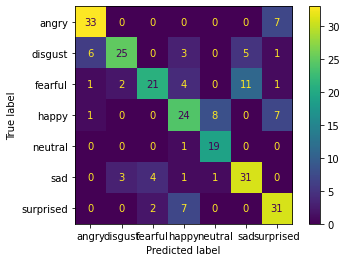

In [83]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_names)

cm_display.plot()
plt.show()

# TESS training

In [107]:
speaker_independet_scenario = True
eval_steps = 10
logging_steps = 10
per_device_train_batch_size= 8
per_device_eval_batch_size= 8
batch_size = 8
num_proc = 1
save_steps = eval_steps * 10    
model_output_dir="wav2vec2-xlsr-model-output-2"
model_name_or_path = "ravdess-model-trained"
pooling_mode = "mean"
model_path = "ravdess-tess-model-trained-2"
csv_save_path="data/csv_files"

In [108]:

data = []
wav_path = "data/TESS/*AF_*/*.wav"

print("all data", len(glob.glob(wav_path)))

for file in glob.glob(wav_path):
  # get the base name of the audio file
  basename = os.path.basename(file)
  # get the emotion label
  emotion = str(Path(file).parent.absolute()).split('/')[-1].split('_')[1]
  # convert to samplerate 16000
  # pac.convert_wav_to_16bit_mono(file, file)
  # print(basename, emotion, file)
  # print(sox.file_info.sample_rate(file))

  try:
    # There are some broken files
    # s = torchaudio.load(os.path.abspath(file))
    data.append({
        "name": basename,
        "path": os.path.abspath(file),
        "emotion": emotion
    })
  except Exception as e:
    print(str(file), e)
    pass

print("final data", len(data))

all data 2402
final data 2402


In [109]:
import random

random.shuffle(data)

df = pd.DataFrame(data)
df.head()

name                                               path  \
0   OAF_thumb_angry.wav  /notebooks/data/TESS/OAF_angry/OAF_thumb_angry...   
1    YAF_mess_angry.wav  /notebooks/data/TESS/YAF_angry/YAF_mess_angry.wav   
2      YAF_make_sad.wav      /notebooks/data/TESS/YAF_sad/YAF_make_sad.wav   
3  YAF_lean_disgust.wav  /notebooks/data/TESS/YAF_disgust/YAF_lean_disg...   
4    OAF_bite_happy.wav  /notebooks/data/TESS/OAF_happy/OAF_bite_happy.wav   

   emotion  
0    angry  
1    angry  
2      sad  
3  disgust  
4    happy

In [110]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()[["path"]]

Labels:  ['angry' 'sad' 'disgust' 'happy' 'surprised' 'fearful' 'neutral']



path
emotion        
angry       400
disgust     201
fearful     201
happy       400
neutral     400
sad         400
surprised   400

In [111]:
csv_save_path = "data/TESS/csv_files"

In [112]:
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=101, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = df_test.reset_index(drop=True)

train_df.to_csv(f"{csv_save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{csv_save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
valid_df.to_csv(f"{csv_save_path}/valid.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(1681, 3)
(721, 3)
(260, 3)


In [113]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": f"{csv_save_path}/train.csv", 
    "validation": f"{csv_save_path}/valid.csv",
    "test": f"{csv_save_path}/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

print(train_dataset)
print(eval_dataset)
print(test_dataset)

Using custom data configuration default-9aef4406501522bf


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9aef4406501522bf/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1681
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 721
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 260
})


In [114]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 7 classes: ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad']

In [128]:
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

loading configuration file ravdess-model-trained/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "ravdess-model-trained",
  "activation_dropout": 0.05,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSpeechClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": true,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "layer",
  "feat_proj_dropout": 0.

In [129]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

loading feature extractor configuration file ravdess-model-trained/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "Wav2Vec2Processor",
  "return_attention_mask": true,
  "sampling_rate": 16000
}

Didn't find file ravdess-model-trained/added_tokens.json. We won't load it.
loading file ravdess-model-trained/vocab.json
loading file ravdess-model-trained/tokenizer_config.json
loading file None
loading file ravdess-model-trained/special_tokens_map.json


The target sampling rate: 16000


In [130]:
def speech_file_to_array_fn(path):
    # print(path)
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [131]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=batch_size,
    batched=True,
    num_proc=num_proc
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=batch_size,
    batched=True,
    num_proc=num_proc
)

  0%|          | 0/211 [00:00<?, ?ba/s]

/usr/local/lib/python3.9/dist-packages/transformers/feature_extraction_utils.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


  0%|          | 0/91 [00:00<?, ?ba/s]

In [132]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [133]:
def model_init():
    model = Wav2Vec2ForSpeechClassification.from_pretrained(
      model_name_or_path,
      config=config
    ).to('cuda')
    model.freeze_feature_extractor()
    return model

In [134]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=model_output_dir,
    # output_dir="/content/gdrive/MyDrive/wav2vec2-xlsr-greek-speech-emotion-recognition"
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=2.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=3e-4, # this was modified from original 1e-4
    save_total_limit=2,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [135]:
model = model_init()

loading weights file ravdess-model-trained/pytorch_model.bin
All model checkpoint weights were used when initializing Wav2Vec2ForSpeechClassification.

All the weights of Wav2Vec2ForSpeechClassification were initialized from the model checkpoint at ravdess-model-trained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Wav2Vec2ForSpeechClassification for predictions without further training.


In [136]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

Using cuda_amp half precision backend


In [137]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: path, emotion, name. If path, emotion, name are not expected by `Wav2Vec2ForSpeechClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1681
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 420


The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: path, emotion, name. If path, emotion, name are not expected by `Wav2Vec2ForSpeechClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 721
  Batch size = 4
Saving model checkpoint to wav2vec2-xlsr-model-output-2/checkpoint-10
Configuration saved in wav2vec2-xlsr-model-output-2/checkpoint-10/config.json
Model weights saved in wav2vec2-xlsr-model-output-2/checkpoint-10/pytorch_model.bin
Feature extractor saved in wav2vec2-xlsr-model-output-2/checkpoint-10/preprocessor_config.json
Deleting older checkpoint [wav2vec2-xlsr-model-output-2/checkpoint-150] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: path, emotion, name. If path, emotion, name are not expected by

TrainOutput(global_step=420, training_loss=0.1539067044144585, metrics={'train_runtime': 3299.7372, 'train_samples_per_second': 1.019, 'train_steps_per_second': 0.127, 'total_flos': 2.4262631041453174e+17, 'train_loss': 0.1539067044144585, 'epoch': 2.0})

In [138]:
trainer.save_model(model_path)
processor.save_pretrained(model_path)

Saving model checkpoint to ravdess-tess-model-trained-2
Configuration saved in ravdess-tess-model-trained-2/config.json
Model weights saved in ravdess-tess-model-trained-2/pytorch_model.bin
Feature extractor saved in ravdess-tess-model-trained-2/preprocessor_config.json
Feature extractor saved in ravdess-tess-model-trained-2/preprocessor_config.json
tokenizer config file saved in ravdess-tess-model-trained-2/tokenizer_config.json
Special tokens file saved in ravdess-tess-model-trained-2/special_tokens_map.json


# * TESS tests **

In [139]:
import torchaudio
torchaudio.load('data/TESS/OAF_angry/OAF_back_angry.wav')

(tensor([[ 0.0000e+00, -2.4414e-04, -2.4414e-04,  ...,  1.5259e-04,
           1.2207e-04,  6.1035e-05]]),
 16000)

In [140]:

data = []
wav_path = "data/TESS/*AF_*/*.wav"
#import pyaudioconvert as pac

print("all data", len(glob.glob(wav_path)))

for file in glob.glob(wav_path):
  # get the base name of the audio file
  basename = os.path.basename(file)
  # get the emotion label
  emotion = str(Path(file).parent.absolute()).split('/')[-1].split('_')[1]
  # print(emotion)
  # convert to samplerate 16000
  #pac.convert_wav_to_16bit_mono(file, file)
  # print(basename, emotion, file)
  # print(sox.file_info.sample_rate(file))

  try:
    # There are some broken files
    # s = torchaudio.load(os.path.abspath(file))
    data.append({
        "name": basename,
        "path": os.path.abspath(file),
        "emotion": emotion
    })
  except Exception as e:
    print(str(file), e)
    pass

print("final data", len(data))

all data 2402
final data 2402


In [141]:
import random

random.shuffle(data)

df = pd.DataFrame(data)
df.head()

name                                               path  \
0    OAF_sheep_angry.wav  /notebooks/data/TESS/OAF_angry/OAF_sheep_angry...   
1        YAF_doll_ps.wav  /notebooks/data/TESS/YAF_surprised/YAF_doll_ps...   
2        OAF_pain_ps.wav  /notebooks/data/TESS/OAF_surprised/OAF_pain_ps...   
3  YAF_death_neutral.wav  /notebooks/data/TESS/YAF_neutral/YAF_death_neu...   
4   YAF_door_disgust.wav  /notebooks/data/TESS/YAF_disgust/YAF_door_disg...   

     emotion  
0      angry  
1  surprised  
2  surprised  
3    neutral  
4    disgust

In [142]:
csv_save_path = "data/TESS/csv_files"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=111, stratify=train_df["emotion"])


train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

train_df.to_csv(f"{csv_save_path}/train2.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{csv_save_path}/test2.csv", sep="\t", encoding="utf-8", index=False)
valid_df.to_csv(f"{csv_save_path}/valid2.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)

(1536, 3)
(481, 3)
(385, 3)


In [143]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [144]:
from datasets import disable_caching
disable_caching()

In [145]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric

csv_save_path = "data/TESS/csv_files"

data_files = {
    "train": f"{csv_save_path}/train2.csv", 
    "validation": f"{csv_save_path}/valid2.csv",
    "test": f"{csv_save_path}/test2.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", download_mode="force_redownload")
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

print(train_dataset)
print(eval_dataset)
print(test_dataset)

Using custom data configuration default-4ad2946a4c88d2fa


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4ad2946a4c88d2fa/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1536
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 385
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 481
})


In [146]:
test_dataset[0]

{'name': 'YAF_fall_neutral.wav',
 'path': '/notebooks/data/TESS/YAF_neutral/YAF_fall_neutral.wav',
 'emotion': 'neutral'}

In [147]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [148]:
test_dataset = test_dataset.map(speech_file_to_array_fn)
result = test_dataset.map(predict, batched=True, batch_size=8)
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

  0%|          | 0/481 [00:00<?, ?ex/s]

/tmp/ipykernel_32/1589267393.py:4: FutureWarning: Pass orig_sr=16000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)


  0%|          | 0/61 [00:00<?, ?ba/s]

['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [104]:
test_dataset = train_dataset.map(speech_file_to_array_fn)
result = test_dataset.map(predict, batched=True, batch_size=8)
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

  0%|          | 0/1536 [00:00<?, ?ex/s]

/tmp/ipykernel_32/1589267393.py:4: FutureWarning: Pass orig_sr=16000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)


  0%|          | 0/192 [00:00<?, ?ba/s]

['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [149]:
for name in result:
    print(name["name"], name["emotion"])
    

YAF_fall_neutral.wav neutral
YAF_shack_sad.wav sad
OAF_cheek_neutral.wav neutral
YAF_far_angry.wav angry
OAF_rot_angry.wav angry
OAF_keg_fear.wav fearful
YAF_sheep_sad.wav sad
OAF_ripe_happy.wav happy
YAF_ripe_happy.wav happy
OAF_bar_sad.wav sad
OAF_thought_happy.wav happy
OAF_yearn_happy.wav happy
YAF_kick_disgust.wav disgust
OAF_beg_angry.wav angry
YAF_chat_ps.wav surprised
OAF_hire_neutral.wav neutral
OAF_witch_sad.wav sad
YAF_get_angry.wav angry
OAF_chain_ps.wav surprised
YAF_size_angry.wav angry
YAF_rag_ps.wav surprised
YAF_date_neutral.wav neutral
OAF_late_angry.wav angry
OAF_puff_neutral.wav neutral
YAF_long_neutral.wav neutral
YAF_week_disgust.wav disgust
OAF_kill_sad.wav sad
OAF_nag_happy.wav happy
YAF_keg_neutral.wav neutral
OAF_late_sad.wav sad
OAF_lean_fear.wav fearful
YAF_white_happy.wav happy
YAF_cheek_neutral.wav neutral
YAF_kill_disgust.wav disgust
YAF_lean_neutral.wav neutral
YAF_hurl_angry.wav angry
YAF_pad_angry.wav angry
OAF_void_happy.wav happy
YAF_witch_ps.wav sur

In [150]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:15])
print(y_pred[:15])



[4, 5, 4, 0, 0, 2, 5, 3, 3, 5, 3, 3, 1, 0, 6]
[4, 5, 4, 0, 0, 2, 5, 3, 3, 5, 3, 3, 1, 0, 6]


In [151]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        80
     disgust       1.00      1.00      1.00        40
     fearful       1.00      1.00      1.00        41
       happy       1.00      1.00      1.00        80
     neutral       1.00      1.00      1.00        80
         sad       1.00      1.00      1.00        80
   surprised       1.00      1.00      1.00        80

    accuracy                           1.00       481
   macro avg       1.00      1.00      1.00       481
weighted avg       1.00      1.00      1.00       481



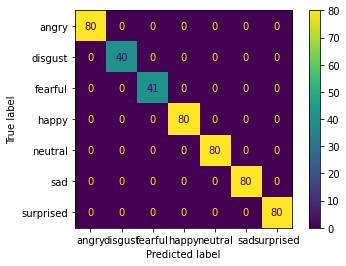

In [152]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_names)

cm_display.plot()
plt.show()

# *** CREMAD tests **

In [42]:
model_name_or_path = 'ravdess-tess-model-trained-2'

In [2]:
# import zipfile
# with zipfile.ZipFile('data/CREMAD/cremad.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

In [4]:
import torchaudio
torchaudio.load('data/CREMAD/1001_DFA_ANG_XX.wav')

(tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.1035e-05, 0.0000e+00,
          0.0000e+00]]),
 16000)

In [18]:
cremad2emotion = {
    "NEU": "neutral",
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "FEA": "fearful",
    "DIS": "disgust"
}

In [20]:
wav_path = "data/CREMAD/*.wav"
emo = glob.glob(wav_path)[0].split('/')[-1].split('_')[-2]
cremad2emotion[emo]


'disgust'

In [21]:

data = []
wav_path = "data/CREMAD/*.wav"
#import pyaudioconvert as pac

print("all data", len(glob.glob(wav_path)))

emos = {'a'}

for file in glob.glob(wav_path):
  # get the base name of the audio file
  basename = os.path.basename(file)
  # get the emotion label
  emotion = file.split('/')[-1].split('_')[-2]
  # print(file, emotion)
  # convert to samplerate 16000
  #pac.convert_wav_to_16bit_mono(file, file)
  # print(basename, emotion, file)
  # print(sox.file_info.sample_rate(file))

  try:
    # There are some broken files
    # s = torchaudio.load(os.path.abspath(file))
    data.append({
        "name": basename,
        "path": os.path.abspath(file),
        "emotion": cremad2emotion[emotion]
    })
  except Exception as e:
    print(str(file), e)
    pass

print(data)

all data 7442
[{'name': '1010_TAI_DIS_XX.wav', 'path': '/notebooks/data/CREMAD/1010_TAI_DIS_XX.wav', 'emotion': 'disgust'}, {'name': '1006_IEO_NEU_XX.wav', 'path': '/notebooks/data/CREMAD/1006_IEO_NEU_XX.wav', 'emotion': 'neutral'}, {'name': '1047_ITH_ANG_XX.wav', 'path': '/notebooks/data/CREMAD/1047_ITH_ANG_XX.wav', 'emotion': 'angry'}, {'name': '1085_TAI_NEU_XX.wav', 'path': '/notebooks/data/CREMAD/1085_TAI_NEU_XX.wav', 'emotion': 'neutral'}, {'name': '1025_DFA_NEU_XX.wav', 'path': '/notebooks/data/CREMAD/1025_DFA_NEU_XX.wav', 'emotion': 'neutral'}, {'name': '1027_IOM_DIS_XX.wav', 'path': '/notebooks/data/CREMAD/1027_IOM_DIS_XX.wav', 'emotion': 'disgust'}, {'name': '1044_IOM_HAP_XX.wav', 'path': '/notebooks/data/CREMAD/1044_IOM_HAP_XX.wav', 'emotion': 'happy'}, {'name': '1057_ITS_HAP_XX.wav', 'path': '/notebooks/data/CREMAD/1057_ITS_HAP_XX.wav', 'emotion': 'happy'}, {'name': '1011_DFA_DIS_XX.wav', 'path': '/notebooks/data/CREMAD/1011_DFA_DIS_XX.wav', 'emotion': 'disgust'}, {'name': '

In [22]:
import random

random.shuffle(data)

df = pd.DataFrame(data)
df.head()

name                                        path  emotion
0  1001_IEO_DIS_MD.wav  /notebooks/data/CREMAD/1001_IEO_DIS_MD.wav  disgust
1  1025_TSI_DIS_XX.wav  /notebooks/data/CREMAD/1025_TSI_DIS_XX.wav  disgust
2  1078_TIE_NEU_XX.wav  /notebooks/data/CREMAD/1078_TIE_NEU_XX.wav  neutral
3  1061_MTI_FEA_XX.wav  /notebooks/data/CREMAD/1061_MTI_FEA_XX.wav  fearful
4  1008_ITH_FEA_XX.wav  /notebooks/data/CREMAD/1008_ITH_FEA_XX.wav  fearful

In [23]:
csv_save_path = "data/CREMAD/csv_files"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=111, stratify=train_df["emotion"])


train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

train_df.to_csv(f"{csv_save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{csv_save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
valid_df.to_csv(f"{csv_save_path}/valid.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)

(4762, 3)
(1489, 3)
(1191, 3)


In [24]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [25]:
from datasets import disable_caching
disable_caching()

In [26]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric

csv_save_path = "data/CREMAD/csv_files"

data_files = {
    "train": f"{csv_save_path}/train.csv", 
    "validation": f"{csv_save_path}/valid.csv",
    "test": f"{csv_save_path}/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", download_mode="force_redownload")
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

print(train_dataset)
print(eval_dataset)
print(test_dataset)

Using custom data configuration default-de183a5df3e0c6e2


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-de183a5df3e0c6e2/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 4762
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1191
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1489
})


In [34]:
import pandas as pd

df = pd.read_table(f'{csv_save_path}/train.csv', delimiter='\t')

print(df.head()) 

                  name                                        path  emotion
0  1069_ITS_SAD_XX.wav  /notebooks/data/CREMAD/1069_ITS_SAD_XX.wav      sad
1  1041_IWW_NEU_XX.wav  /notebooks/data/CREMAD/1041_IWW_NEU_XX.wav  neutral
2  1070_ITS_DIS_XX.wav  /notebooks/data/CREMAD/1070_ITS_DIS_XX.wav  disgust
3  1009_TSI_ANG_XX.wav  /notebooks/data/CREMAD/1009_TSI_ANG_XX.wav    angry
4  1026_IWW_HAP_XX.wav  /notebooks/data/CREMAD/1026_IWW_HAP_XX.wav    happy


In [36]:
train_dataset.to_pandas()

name                                        path  emotion
0     1069_ITS_SAD_XX.wav  /notebooks/data/CREMAD/1069_ITS_SAD_XX.wav      sad
1     1041_IWW_NEU_XX.wav  /notebooks/data/CREMAD/1041_IWW_NEU_XX.wav  neutral
2     1070_ITS_DIS_XX.wav  /notebooks/data/CREMAD/1070_ITS_DIS_XX.wav  disgust
3     1009_TSI_ANG_XX.wav  /notebooks/data/CREMAD/1009_TSI_ANG_XX.wav    angry
4     1026_IWW_HAP_XX.wav  /notebooks/data/CREMAD/1026_IWW_HAP_XX.wav    happy
...                   ...                                         ...      ...
4757  1049_IEO_ANG_HI.wav  /notebooks/data/CREMAD/1049_IEO_ANG_HI.wav    angry
4758  1084_MTI_FEA_XX.wav  /notebooks/data/CREMAD/1084_MTI_FEA_XX.wav  fearful
4759  1054_DFA_SAD_XX.wav  /notebooks/data/CREMAD/1054_DFA_SAD_XX.wav      sad
4760  1059_ITH_ANG_XX.wav  /notebooks/data/CREMAD/1059_ITH_ANG_XX.wav    angry
4761  1018_IEO_FEA_MD.wav  /notebooks/data/CREMAD/1018_IEO_FEA_MD.wav  fearful

[4762 rows x 3 columns]

In [37]:
eval_dataset.to_pandas()

name                                        path  emotion
0     1076_IEO_ANG_MD.wav  /notebooks/data/CREMAD/1076_IEO_ANG_MD.wav    angry
1     1061_ITS_NEU_XX.wav  /notebooks/data/CREMAD/1061_ITS_NEU_XX.wav  neutral
2     1090_MTI_ANG_XX.wav  /notebooks/data/CREMAD/1090_MTI_ANG_XX.wav    angry
3     1076_TAI_FEA_XX.wav  /notebooks/data/CREMAD/1076_TAI_FEA_XX.wav  fearful
4     1003_TSI_SAD_XX.wav  /notebooks/data/CREMAD/1003_TSI_SAD_XX.wav      sad
...                   ...                                         ...      ...
1186  1088_TIE_FEA_XX.wav  /notebooks/data/CREMAD/1088_TIE_FEA_XX.wav  fearful
1187  1018_TSI_SAD_XX.wav  /notebooks/data/CREMAD/1018_TSI_SAD_XX.wav      sad
1188  1057_TAI_ANG_XX.wav  /notebooks/data/CREMAD/1057_TAI_ANG_XX.wav    angry
1189  1080_IOM_SAD_XX.wav  /notebooks/data/CREMAD/1080_IOM_SAD_XX.wav      sad
1190  1075_DFA_DIS_XX.wav  /notebooks/data/CREMAD/1075_DFA_DIS_XX.wav  disgust

[1191 rows x 3 columns]

In [38]:
test_dataset.to_pandas()

name                                        path  emotion
0     1050_IEO_NEU_XX.wav  /notebooks/data/CREMAD/1050_IEO_NEU_XX.wav  neutral
1     1042_ITS_NEU_XX.wav  /notebooks/data/CREMAD/1042_ITS_NEU_XX.wav  neutral
2     1057_IEO_DIS_MD.wav  /notebooks/data/CREMAD/1057_IEO_DIS_MD.wav  disgust
3     1024_MTI_NEU_XX.wav  /notebooks/data/CREMAD/1024_MTI_NEU_XX.wav  neutral
4     1053_ITH_NEU_XX.wav  /notebooks/data/CREMAD/1053_ITH_NEU_XX.wav  neutral
...                   ...                                         ...      ...
1484  1091_MTI_HAP_XX.wav  /notebooks/data/CREMAD/1091_MTI_HAP_XX.wav    happy
1485  1064_IEO_FEA_HI.wav  /notebooks/data/CREMAD/1064_IEO_FEA_HI.wav  fearful
1486  1002_IWW_HAP_XX.wav  /notebooks/data/CREMAD/1002_IWW_HAP_XX.wav    happy
1487  1009_TIE_SAD_XX.wav  /notebooks/data/CREMAD/1009_TIE_SAD_XX.wav      sad
1488  1006_WSI_ANG_XX.wav  /notebooks/data/CREMAD/1006_WSI_ANG_XX.wav    angry

[1489 rows x 3 columns]

In [39]:
import random

random.shuffle(data)

df = pd.DataFrame(data)
df.head()

name                                        path  emotion
0  1082_WSI_DIS_XX.wav  /notebooks/data/CREMAD/1082_WSI_DIS_XX.wav  disgust
1  1038_IEO_ANG_HI.wav  /notebooks/data/CREMAD/1038_IEO_ANG_HI.wav    angry
2  1062_IEO_HAP_HI.wav  /notebooks/data/CREMAD/1062_IEO_HAP_HI.wav    happy
3  1003_IOM_DIS_XX.wav  /notebooks/data/CREMAD/1003_IOM_DIS_XX.wav  disgust
4  1012_DFA_SAD_XX.wav  /notebooks/data/CREMAD/1012_DFA_SAD_XX.wav      sad

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [48]:
# import torch
# import torch.nn as nn
# from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# from transformers.models.wav2vec2.modeling_wav2vec2 import (
#     Wav2Vec2PreTrainedModel,
#     Wav2Vec2Model
# )


class Wav2Vec2ClassificationHead(nn.Module):
    def __init__(self, config):        
        super().__init__()
        self.config = config
        self.relu=nn.ReLU()
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.relu(x)
        x = self.out_proj(x)
        return x

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [51]:
# from dataclasses import dataclass
# from typing import Optional, Tuple
# import torch
# from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [49]:
validation_model_name_or_path = "ravdess-tess-model-trained-2/"
config = AutoConfig.from_pretrained(validation_model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(validation_model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(validation_model_name_or_path).to(device)

In [52]:
test_dataset = test_dataset.map(speech_file_to_array_fn)
result = test_dataset.map(predict, batched=True, batch_size=8)
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

  0%|          | 0/1489 [00:00<?, ?ex/s]

/tmp/ipykernel_32/1589267393.py:4: FutureWarning: Pass orig_sr=16000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)


  0%|          | 0/187 [00:00<?, ?ba/s]

['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [53]:
for name in result:
    print(name["name"], name["emotion"])

1050_IEO_NEU_XX.wav neutral
1042_ITS_NEU_XX.wav neutral
1057_IEO_DIS_MD.wav disgust
1024_MTI_NEU_XX.wav neutral
1053_ITH_NEU_XX.wav neutral
1079_ITH_HAP_XX.wav happy
1027_WSI_FEA_XX.wav fearful
1042_TIE_SAD_XX.wav sad
1050_ITH_SAD_XX.wav sad
1091_IWL_FEA_XX.wav fearful
1022_TIE_HAP_XX.wav happy
1040_MTI_DIS_XX.wav disgust
1030_TIE_DIS_XX.wav disgust
1076_DFA_DIS_XX.wav disgust
1090_IEO_DIS_MD.wav disgust
1035_IEO_HAP_HI.wav happy
1054_TIE_DIS_XX.wav disgust
1017_ITH_NEU_XX.wav neutral
1012_TIE_ANG_XX.wav angry
1026_TSI_ANG_XX.wav angry
1009_ITS_FEA_XX.wav fearful
1050_IWW_DIS_XX.wav disgust
1006_TSI_DIS_XX.wav disgust
1024_ITH_SAD_XX.wav sad
1010_ITS_SAD_XX.wav sad
1020_ITH_NEU_XX.wav neutral
1019_MTI_ANG_XX.wav angry
1043_TAI_DIS_XX.wav disgust
1002_MTI_DIS_XX.wav disgust
1008_IWW_ANG_XX.wav angry
1084_ITS_NEU_XX.wav neutral
1060_TIE_FEA_XX.wav fearful
1080_ITS_NEU_XX.wav neutral
1008_ITH_FEA_XX.wav fearful
1018_IWL_FEA_XX.wav fearful
1087_DFA_HAP_XX.wav happy
1078_TIE_DIS_XX.wav disg

KeyboardInterrupt: 

In [54]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:15])
print(y_pred[:15])

[4, 4, 1, 4, 4, 3, 2, 5, 5, 2, 3, 1, 1, 1, 1]
[3, 4, 1, 4, 6, 3, 3, 4, 5, 2, 4, 1, 4, 4, 1]


In [55]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       angry       0.77      0.49      0.60       254
     disgust       0.46      0.32      0.38       254
     fearful       0.56      0.37      0.45       254
       happy       0.38      0.39      0.38       255
     neutral       0.54      0.50      0.52       218
         sad       0.45      0.50      0.47       254
   surprised       0.00      0.00      0.00         0

    accuracy                           0.43      1489
   macro avg       0.45      0.37      0.40      1489
weighted avg       0.52      0.43      0.46      1489



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


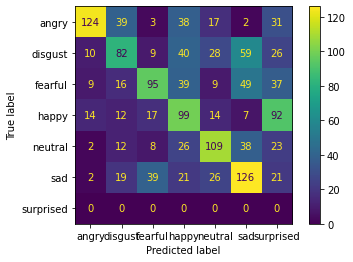

In [56]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_names)

cm_display.plot()
plt.show()

# ** EmoReact tests (happiness)**

In [57]:
import zipfile
with zipfile.ZipFile('data/EmoReact/test-happy/emoreact_happy.zip', 'r') as zip_ref:
    zip_ref.extractall('data/EmoReact/test-happy')

In [168]:
file1 = open('data/EmoReact/test-happy/Test_names_original.txt', 'r')
Lines = file1.readlines()
  
list_of_names = []
# Strips the newline character
for line in Lines:
    list_of_names.append(line.strip())

# keys_list = list(list_of_names)
# key = keys_list[0]

print(len(list_of_names))
    
file2 = open('data/EmoReact/test-happy/test_labels.txt', 'r')
Lines = file2.readlines()
  
dict_name_labels_test = {}
file_index = 0
# Strips the newline character
for line in Lines:
  # check if sound file exists. if does not exist, just skip to the next file name.
  if (os.path.exists('data/EmoReact/test-happy/test/' + list_of_names[file_index].split('.')[0][1:] + '.wav')):
    # dict_name_labels[list_of_names[count]] = [float(x) for x in line.strip().split(',')]
    # initialize tensor with zero values for all emotions
    dict_name_labels_test[list_of_names[file_index]] = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0])
    emotion_index = 0
    current_label = dict_name_labels_test[list_of_names[file_index]]
    # ignore last column - valence
    for x in line.strip().split(',')[:-1]:
        if float(x) == 1.0:
            current_label[emotion_index] = 1
        emotion_index += 1
  file_index+=1

print(len(dict_name_labels_test))
print(dict_name_labels_test)

367
358
{"'ANNOYING_ORANGE120_2.mp4'": tensor([0, 1, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE127_2.mp4'": tensor([0, 0, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE152_2.mp4'": tensor([0, 0, 0, 0, 0, 0, 0, 0]), "'ANNOYING_ORANGE158_2.mp4'": tensor([0, 0, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE168_2.mp4'": tensor([1, 1, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE170_2.mp4'": tensor([0, 0, 0, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE176_2.mp4'": tensor([0, 0, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE83_2.mp4'": tensor([0, 0, 0, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE89_2.mp4'": tensor([0, 0, 0, 1, 0, 0, 0, 0]), "'APPLEWATCH11_2.mp4'": tensor([0, 1, 1, 1, 1, 0, 0, 0]), "'APPLEWATCH13_2.mp4'": tensor([1, 1, 0, 0, 1, 0, 0, 0]), "'APPLEWATCH15_2.mp4'": tensor([1, 0, 0, 1, 0, 0, 0, 0]), "'APPLEWATCH17_2.mp4'": tensor([1, 0, 1, 1, 1, 0, 0, 0]), "'APPLEWATCH20_2.mp4'": tensor([1, 1, 0, 0, 0, 0, 0, 0]), "'APPLEWATCH21_2.mp4'": tensor([0, 0, 0, 0, 1, 0, 0, 0]), "'APPLEWATCH27_2.mp4'": tensor([0, 0, 1, 0, 0, 0, 0, 0]), "'APPLEWATC

In [169]:
for file in dict_name_labels_test:
  print(dict_name_labels_test[file])

tensor([0, 1, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 1, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 0, 1, 1, 1, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([0,

In [170]:
test_4_happiness = []

for file in dict_name_labels_test:
  # get the base name of the audio file
  basename = file[1:-1].split('.')[0] + '.wav'
  # get the emotion label
  emotion = dict_name_labels_test[file]
  # print(basename, emotion, file)

  try:
    # There are some broken files
    # s = torchaudio.load(('/content/gdrive/MyDrive/PhD/wav2vec/EmoReact_V_1.0/sound/all/' + basename))
    
    # add only files annotated with 'happy'
    if float(emotion[3]) == 1.0:
        test_4_happiness.append({
            "name": basename,
            "path": 'data/EmoReact/test-happy/test/' + basename,
            "emotion": 'happy'
        })
    
  except Exception as e:
    print(str(file), e)
    pass

print(len(test_4_happiness))

204


In [171]:
df4 = pd.DataFrame(test_4_happiness)
df4

name  \
0    ANNOYING_ORANGE120_2.wav   
1    ANNOYING_ORANGE127_2.wav   
2    ANNOYING_ORANGE158_2.wav   
3    ANNOYING_ORANGE168_2.wav   
4    ANNOYING_ORANGE170_2.wav   
..                        ...   
199              iPOD25_2.wav   
200              iPOD35_2.wav   
201              iPOD73_2.wav   
202              iPOD83_2.wav   
203              iPOD93_2.wav   

                                                  path emotion  
0    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
1    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
2    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
3    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
4    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
..                                                 ...     ...  
199         data/EmoReact/test-happy/test/iPOD25_2.wav   happy  
200         data/EmoReact/test-happy/test/iPOD35_2.wav   happy  
201         data/EmoReact/test-happy/test/iPOD73_2.wav   happy  
202         data/EmoReact/test-happy/test/iPOD83_2.wav   happy  
203         data/EmoReact/test-happy/test/iPOD93_2.wav   happy  

[204 rows x 3 columns]

In [172]:
print("Labels: ", df4["emotion"].unique())
print()
df4.groupby("emotion").count()[["path"]]

Labels:  ['happy']



path
emotion      
happy     204

In [173]:
save_path = "data/EmoReact/test-happy/csv_files/happiness"
df4.to_csv(f"{save_path}/testtest.csv", sep="\t", encoding="utf-8", index=False)

In [174]:
from datasets import load_dataset, load_metric


data_files = {
    "testtest": "data/EmoReact/test-happy/csv_files/happiness/testtest.csv", 
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
test_dataset = dataset["testtest"]

print(test_dataset)

Using custom data configuration default-e2e3df2a5ef68bf3


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e2e3df2a5ef68bf3/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 204
})


In [175]:
input_column = "path"
output_column = "emotion"

In [176]:
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 6 classes: ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad']


In [177]:
test_dataset.to_pandas()

name  \
0    ANNOYING_ORANGE120_2.wav   
1    ANNOYING_ORANGE127_2.wav   
2    ANNOYING_ORANGE158_2.wav   
3    ANNOYING_ORANGE168_2.wav   
4    ANNOYING_ORANGE170_2.wav   
..                        ...   
199              iPOD25_2.wav   
200              iPOD35_2.wav   
201              iPOD73_2.wav   
202              iPOD83_2.wav   
203              iPOD93_2.wav   

                                                  path emotion  
0    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
1    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
2    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
3    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
4    data/EmoReact/test-happy/test/ANNOYING_ORANGE1...   happy  
..                                                 ...     ...  
199         data/EmoReact/test-happy/test/iPOD25_2.wav   happy  
200         data/EmoReact/test-happy/test/iPOD35_2.wav   happy  
201         data/EmoReact/test-happy/test/iPOD73_2.wav   happy  
202         data/EmoReact/test-happy/test/iPOD83_2.wav   happy  
203         data/EmoReact/test-happy/test/iPOD93_2.wav   happy  

[204 rows x 3 columns]

In [178]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [179]:
test_dataset = test_dataset.map(speech_file_to_array_fn)
result = test_dataset.map(predict, batched=True, batch_size=8)
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

  0%|          | 0/204 [00:00<?, ?ex/s]

/tmp/ipykernel_32/1589267393.py:4: FutureWarning: Pass orig_sr=16000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)


  0%|          | 0/26 [00:00<?, ?ba/s]

['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [89]:
for name in result:
    print(name["name"], name["emotion"])

ANNOYING_ORANGE120_2.wav happy
ANNOYING_ORANGE127_2.wav happy
ANNOYING_ORANGE158_2.wav happy
ANNOYING_ORANGE168_2.wav happy
ANNOYING_ORANGE170_2.wav happy
ANNOYING_ORANGE176_2.wav happy
ANNOYING_ORANGE83_2.wav happy
ANNOYING_ORANGE89_2.wav happy
APPLEWATCH11_2.wav happy
APPLEWATCH15_2.wav happy
APPLEWATCH17_2.wav happy
APPLEWATCH43_2.wav happy
BRUSSELSSPROUTS61_2.wav happy
BULLYING151_2.wav happy
BULLYING153_2.wav happy
CAKE63_2.wav happy
CAN_YOUR_PET15_2.wav happy
CAN_YOUR_PET22_2.wav happy
CAN_YOUR_PET31_2.wav happy
CAN_YOUR_PET33_2.wav happy
CAN_YOUR_PET47_2.wav happy
CAN_YOUR_PET7_2.wav happy
CAN_YOUR_PET90_2.wav happy
CAVIAR19_2.wav happy
CAVIAR76_2.wav happy
CAVIAR85_2.wav happy
COWTONGUE38_2.wav happy
DUBSTEP108_2.wav happy
DUBSTEP113_2.wav happy
DUBSTEP115_2.wav happy
DUBSTEP13_2.wav happy
DUBSTEP23_2.wav happy
DUBSTEP33_2.wav happy
DUBSTEP49_2.wav happy
DUBSTEP59_2.wav happy
DUBSTEP68_2.wav happy
DUBSTEP90_2.wav happy
DUBSTEP95_2.wav happy
ESCARGOT120_2.wav happy
FROGLEGS59_2.

In [180]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:15])
print(y_pred[:15])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[6, 3, 6, 3, 3, 1, 4, 5, 3, 6, 6, 3, 6, 3, 0]


In [181]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         0
     disgust       0.00      0.00      0.00         0
     fearful       0.00      0.00      0.00         0
       happy       1.00      0.29      0.45       204
     neutral       0.00      0.00      0.00         0
         sad       0.00      0.00      0.00         0
   surprised       0.00      0.00      0.00         0

    accuracy                           0.29       204
   macro avg       0.14      0.04      0.06       204
weighted avg       1.00      0.29      0.45       204



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


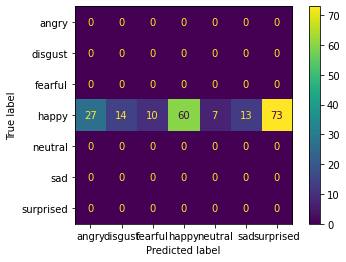

In [151]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_names)

cm_display.plot()
plt.show()

# ** EmoReact tests (disgust[sadness?])**

In [1]:
import zipfile
with zipfile.ZipFile('data/EmoReact/test-happy/emoreact_train.zip', 'r') as zip_ref:
    zip_ref.extractall('data/EmoReact/train')

In [5]:
file1 = open('data/EmoReact/test-happy/Train_names_original.txt', 'r')
Lines = file1.readlines()
  
list_of_names = []
# Strips the newline character
for line in Lines:
    list_of_names.append(line.strip())

# keys_list = list(list_of_names)
# key = keys_list[0]

print(len(list_of_names))
    
file2 = open('data/EmoReact/test-happy/train_labels.txt', 'r')
Lines = file2.readlines()
  
dict_name_labels_test = {}
file_index = 0
# Strips the newline character
for line in Lines:
  # check if sound file exists. if does not exist, just skip to the next file name.
  if (os.path.exists('data/EmoReact/test-happy/train/' + list_of_names[file_index].split('.')[0][1:] + '.wav')):
    # dict_name_labels[list_of_names[count]] = [float(x) for x in line.strip().split(',')]
    # initialize tensor with zero values for all emotions
    dict_name_labels_test[list_of_names[file_index]] = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0])
    emotion_index = 0
    current_label = dict_name_labels_test[list_of_names[file_index]]
    # ignore last column - valence
    for x in line.strip().split(',')[:-1]:
        if float(x) == 1.0:
            current_label[emotion_index] = 1
        emotion_index += 1
  file_index+=1

print(len(dict_name_labels_test))
print(dict_name_labels_test)

432
420
{"'ANNOYING_ORANGE105_2.mp4'": tensor([0, 0, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE119_2.mp4'": tensor([0, 0, 0, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE11_2.mp4'": tensor([0, 0, 0, 1, 0, 1, 0, 0]), "'ANNOYING_ORANGE123_2.mp4'": tensor([1, 0, 1, 1, 1, 0, 0, 0]), "'ANNOYING_ORANGE126_2.mp4'": tensor([0, 0, 0, 0, 0, 0, 0, 0]), "'ANNOYING_ORANGE155_2.mp4'": tensor([0, 0, 0, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE157_2.mp4'": tensor([0, 0, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE159_2.mp4'": tensor([0, 0, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE162_2.mp4'": tensor([0, 1, 1, 0, 0, 0, 0, 0]), "'ANNOYING_ORANGE166_2.mp4'": tensor([0, 0, 1, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE169_2.mp4'": tensor([1, 0, 0, 1, 1, 0, 0, 0]), "'ANNOYING_ORANGE171_2.mp4'": tensor([0, 0, 0, 0, 0, 0, 0, 0]), "'ANNOYING_ORANGE172_2.mp4'": tensor([0, 0, 0, 0, 0, 0, 0, 0]), "'ANNOYING_ORANGE174_2.mp4'": tensor([0, 0, 0, 0, 0, 0, 0, 0]), "'ANNOYING_ORANGE175_2.mp4'": tensor([0, 0, 0, 1, 0, 0, 0, 0]), "'ANNOYING_ORANGE30_2.mp4'": ten

In [9]:
test_7_fear = []

for file in dict_name_labels_test:
  # get the base name of the audio file
  basename = file[1:-1].split('.')[0] + '.wav'
  # get the emotion label
  emotion = dict_name_labels_test[file]
  # print(basename, emotion, file)

  try:
    # There are some broken files
    # s = torchaudio.load(('/content/gdrive/MyDrive/PhD/wav2vec/EmoReact_V_1.0/sound/all/' + basename))
    
    # add only files annotated with 'happy'
    if float(emotion[5]) == 1.0:
        test_7_fear.append({
            "name": basename,
            "path": 'data/EmoReact/test-happy/train/' + basename,
            "emotion": 'disgust'
        })
    
  except Exception as e:
    print(str(file), e)
    pass

print(len(test_7_fear))

60


In [10]:
df7 = pd.DataFrame(test_7_fear)
df7

name  \
0   ANNOYING_ORANGE11_2.wav   
1   ANNOYING_ORANGE30_2.wav   
2         BULLYING109_2.wav   
3         BULLYING131_2.wav   
4         BULLYING146_2.wav   
5          BULLYING26_2.wav   
6          BULLYING47_2.wav   
7      CAN_YOUR_PET80_2.wav   
8      CAN_YOUR_PET88_2.wav   
9      CAN_YOUR_PET96_2.wav   
10           CAVIAR11_2.wav   
11           CAVIAR75_2.wav   
12           CAVIAR84_2.wav   
13       COWTONGUE102_2.wav   
14        COWTONGUE40_2.wav   
15        COWTONGUE44_2.wav   
16         COWTONGUE5_2.wav   
17        COWTONGUE69_2.wav   
18        ESCARGOT103_2.wav   
19         ESCARGOT47_2.wav   
20         FROGLEGS27_2.wav   
21         FROGLEGS28_2.wav   
22         FROGLEGS32_2.wav   
23         FROGLEGS63_2.wav   
24         FROGLEGS87_2.wav   
25    Gay_Marriage143_2.wav   
26    Gay_Marriage201_2.wav   
27      MAKEUP_APPS25_2.wav   
28   PIZZATOPPINGS110_2.wav   
29   PIZZATOPPINGS112_2.wav   
30          REBECCA21_2.wav   
31          REBECCA40_2.wav   
32          REBECCA41_2.wav   
33             SPAM75_2.wav   
34             SQUID3_2.wav   
35            SQUID82_2.wav   
36            SQUID87_2.wav   
37           SUSHI100_2.wav   
38           SUSHI101_2.wav   
39           SUSHI125_2.wav   
40            SUSHI14_2.wav   
41             SUSHI2_2.wav   
42            SUSHI39_2.wav   
43            SUSHI73_2.wav   
44            SUSHI79_2.wav   
45            SUSHI92_2.wav   
46    SWING_COPTERS64_2.wav   
47             TOFU39_2.wav   
48             TOFU41_2.wav   
49             TOFU85_2.wav   
50           TOILET88_2.wav   
51         VEGEMITE20_2.wav   
52         VEGEMITE53_2.wav   
53         VEGEMITE62_2.wav   
54         VEGEMITE66_2.wav   
55         VEGEMITE69_2.wav   
56         VEGEMITE74_2.wav   
57         VEGEMITE96_2.wav   
58       WHEATGRASS86_2.wav   
59             iPOD58_2.wav   

                                                 path  emotion  
0   data/EmoReact/test-happy/train/ANNOYING_ORANGE...  disgust  
1   data/EmoReact/test-happy/train/ANNOYING_ORANGE...  disgust  
2    data/EmoReact/test-happy/train/BULLYING109_2.wav  disgust  
3    data/EmoReact/test-happy/train/BULLYING131_2.wav  disgust  
4    data/EmoReact/test-happy/train/BULLYING146_2.wav  disgust  
5     data/EmoReact/test-happy/train/BULLYING26_2.wav  disgust  
6     data/EmoReact/test-happy/train/BULLYING47_2.wav  disgust  
7   data/EmoReact/test-happy/train/CAN_YOUR_PET80_...  disgust  
8   data/EmoReact/test-happy/train/CAN_YOUR_PET88_...  disgust  
9   data/EmoReact/test-happy/train/CAN_YOUR_PET96_...  disgust  
10      data/EmoReact/test-happy/train/CAVIAR11_2.wav  disgust  
11      data/EmoReact/test-happy/train/CAVIAR75_2.wav  disgust  
12      data/EmoReact/test-happy/train/CAVIAR84_2.wav  disgust  
13  data/EmoReact/test-happy/train/COWTONGUE102_2.wav  disgust  
14   data/EmoReact/test-happy/train/COWTONGUE40_2.wav  disgust  
15   data/EmoReact/test-happy/train/COWTONGUE44_2.wav  disgust  
16    data/EmoReact/test-happy/train/COWTONGUE5_2.wav  disgust  
17   data/EmoReact/test-happy/train/COWTONGUE69_2.wav  disgust  
18   data/EmoReact/test-happy/train/ESCARGOT103_2.wav  disgust  
19    data/EmoReact/test-happy/train/ESCARGOT47_2.wav  disgust  
20    data/EmoReact/test-happy/train/FROGLEGS27_2.wav  disgust  
21    data/EmoReact/test-happy/train/FROGLEGS28_2.wav  disgust  
22    data/EmoReact/test-happy/train/FROGLEGS32_2.wav  disgust  
23    data/EmoReact/test-happy/train/FROGLEGS63_2.wav  disgust  
24    data/EmoReact/test-happy/train/FROGLEGS87_2.wav  disgust  
25  data/EmoReact/test-happy/train/Gay_Marriage143...  disgust  
26  data/EmoReact/test-happy/train/Gay_Marriage201...  disgust  
27  data/EmoReact/test-happy/train/MAKEUP_APPS25_2...  disgust  
28  data/EmoReact/test-happy/train/PIZZATOPPINGS11...  disgust  
29  data/EmoReact/test-happy/train/PIZZATOPPINGS11...  disgust  
30     data/EmoReact/test-happy/train/REBECCA21_2.wav  disgust  
31     data/EmoReact/test-happy/train/REBECCA40_2.w

In [13]:
print("Labels: ", df7["emotion"].unique())
print()
df7.groupby("emotion").count()[["path"]]

Labels:  ['disgust']



path
emotion      
disgust    60

In [14]:
save_path = "data/EmoReact/test-happy/csv_files/fearful"
df7.to_csv(f"{save_path}/testtest.csv", sep="\t", encoding="utf-8", index=False)

In [15]:
from datasets import load_dataset, load_metric


data_files = {
    "testtest": "data/EmoReact/test-happy/csv_files/fearful/testtest.csv", 
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
test_dataset = dataset["testtest"]

print(test_dataset)

Using custom data configuration default-fa4c3edaf8cca5a9


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fa4c3edaf8cca5a9/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 60
})


In [16]:
input_column = "path"
output_column = "emotion"

In [18]:
label_list = test_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 1 classes: ['disgust']


In [19]:
test_dataset.to_pandas()

name  \
0   ANNOYING_ORANGE11_2.wav   
1   ANNOYING_ORANGE30_2.wav   
2         BULLYING109_2.wav   
3         BULLYING131_2.wav   
4         BULLYING146_2.wav   
5          BULLYING26_2.wav   
6          BULLYING47_2.wav   
7      CAN_YOUR_PET80_2.wav   
8      CAN_YOUR_PET88_2.wav   
9      CAN_YOUR_PET96_2.wav   
10           CAVIAR11_2.wav   
11           CAVIAR75_2.wav   
12           CAVIAR84_2.wav   
13       COWTONGUE102_2.wav   
14        COWTONGUE40_2.wav   
15        COWTONGUE44_2.wav   
16         COWTONGUE5_2.wav   
17        COWTONGUE69_2.wav   
18        ESCARGOT103_2.wav   
19         ESCARGOT47_2.wav   
20         FROGLEGS27_2.wav   
21         FROGLEGS28_2.wav   
22         FROGLEGS32_2.wav   
23         FROGLEGS63_2.wav   
24         FROGLEGS87_2.wav   
25    Gay_Marriage143_2.wav   
26    Gay_Marriage201_2.wav   
27      MAKEUP_APPS25_2.wav   
28   PIZZATOPPINGS110_2.wav   
29   PIZZATOPPINGS112_2.wav   
30          REBECCA21_2.wav   
31          REBECCA40_2.wav   
32          REBECCA41_2.wav   
33             SPAM75_2.wav   
34             SQUID3_2.wav   
35            SQUID82_2.wav   
36            SQUID87_2.wav   
37           SUSHI100_2.wav   
38           SUSHI101_2.wav   
39           SUSHI125_2.wav   
40            SUSHI14_2.wav   
41             SUSHI2_2.wav   
42            SUSHI39_2.wav   
43            SUSHI73_2.wav   
44            SUSHI79_2.wav   
45            SUSHI92_2.wav   
46    SWING_COPTERS64_2.wav   
47             TOFU39_2.wav   
48             TOFU41_2.wav   
49             TOFU85_2.wav   
50           TOILET88_2.wav   
51         VEGEMITE20_2.wav   
52         VEGEMITE53_2.wav   
53         VEGEMITE62_2.wav   
54         VEGEMITE66_2.wav   
55         VEGEMITE69_2.wav   
56         VEGEMITE74_2.wav   
57         VEGEMITE96_2.wav   
58       WHEATGRASS86_2.wav   
59             iPOD58_2.wav   

                                                 path  emotion  
0   data/EmoReact/test-happy/train/ANNOYING_ORANGE...  disgust  
1   data/EmoReact/test-happy/train/ANNOYING_ORANGE...  disgust  
2    data/EmoReact/test-happy/train/BULLYING109_2.wav  disgust  
3    data/EmoReact/test-happy/train/BULLYING131_2.wav  disgust  
4    data/EmoReact/test-happy/train/BULLYING146_2.wav  disgust  
5     data/EmoReact/test-happy/train/BULLYING26_2.wav  disgust  
6     data/EmoReact/test-happy/train/BULLYING47_2.wav  disgust  
7   data/EmoReact/test-happy/train/CAN_YOUR_PET80_...  disgust  
8   data/EmoReact/test-happy/train/CAN_YOUR_PET88_...  disgust  
9   data/EmoReact/test-happy/train/CAN_YOUR_PET96_...  disgust  
10      data/EmoReact/test-happy/train/CAVIAR11_2.wav  disgust  
11      data/EmoReact/test-happy/train/CAVIAR75_2.wav  disgust  
12      data/EmoReact/test-happy/train/CAVIAR84_2.wav  disgust  
13  data/EmoReact/test-happy/train/COWTONGUE102_2.wav  disgust  
14   data/EmoReact/test-happy/train/COWTONGUE40_2.wav  disgust  
15   data/EmoReact/test-happy/train/COWTONGUE44_2.wav  disgust  
16    data/EmoReact/test-happy/train/COWTONGUE5_2.wav  disgust  
17   data/EmoReact/test-happy/train/COWTONGUE69_2.wav  disgust  
18   data/EmoReact/test-happy/train/ESCARGOT103_2.wav  disgust  
19    data/EmoReact/test-happy/train/ESCARGOT47_2.wav  disgust  
20    data/EmoReact/test-happy/train/FROGLEGS27_2.wav  disgust  
21    data/EmoReact/test-happy/train/FROGLEGS28_2.wav  disgust  
22    data/EmoReact/test-happy/train/FROGLEGS32_2.wav  disgust  
23    data/EmoReact/test-happy/train/FROGLEGS63_2.wav  disgust  
24    data/EmoReact/test-happy/train/FROGLEGS87_2.wav  disgust  
25  data/EmoReact/test-happy/train/Gay_Marriage143...  disgust  
26  data/EmoReact/test-happy/train/Gay_Marriage201...  disgust  
27  data/EmoReact/test-happy/train/MAKEUP_APPS25_2...  disgust  
28  data/EmoReact/test-happy/train/PIZZATOPPINGS11...  disgust  
29  data/EmoReact/test-happy/train/PIZZATOPPINGS11...  disgust  
30     data/EmoReact/test-happy/train/REBECCA21_2.wav  disgust  
31     data/EmoReact/test-happy/train/REBECCA40_2.w

In [20]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [26]:
test_dataset = test_dataset.map(speech_file_to_array_fn)
result = test_dataset.map(predict, batched=True, batch_size=8)
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

  0%|          | 0/60 [00:00<?, ?ex/s]

/tmp/ipykernel_33/1589267393.py:4: FutureWarning: Pass orig_sr=16000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)


  0%|          | 0/8 [00:00<?, ?ba/s]

['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [27]:
for name in result:
    print(name["name"], name["emotion"])
    

ANNOYING_ORANGE11_2.wav disgust
ANNOYING_ORANGE30_2.wav disgust
BULLYING109_2.wav disgust
BULLYING131_2.wav disgust
BULLYING146_2.wav disgust
BULLYING26_2.wav disgust
BULLYING47_2.wav disgust
CAN_YOUR_PET80_2.wav disgust
CAN_YOUR_PET88_2.wav disgust
CAN_YOUR_PET96_2.wav disgust
CAVIAR11_2.wav disgust
CAVIAR75_2.wav disgust
CAVIAR84_2.wav disgust
COWTONGUE102_2.wav disgust
COWTONGUE40_2.wav disgust
COWTONGUE44_2.wav disgust
COWTONGUE5_2.wav disgust
COWTONGUE69_2.wav disgust
ESCARGOT103_2.wav disgust
ESCARGOT47_2.wav disgust
FROGLEGS27_2.wav disgust
FROGLEGS28_2.wav disgust
FROGLEGS32_2.wav disgust
FROGLEGS63_2.wav disgust
FROGLEGS87_2.wav disgust
Gay_Marriage143_2.wav disgust
Gay_Marriage201_2.wav disgust
MAKEUP_APPS25_2.wav disgust
PIZZATOPPINGS110_2.wav disgust
PIZZATOPPINGS112_2.wav disgust
REBECCA21_2.wav disgust
REBECCA40_2.wav disgust
REBECCA41_2.wav disgust
SPAM75_2.wav disgust
SQUID3_2.wav disgust
SQUID82_2.wav disgust
SQUID87_2.wav disgust
SUSHI100_2.wav disgust
SUSHI101_2.wav 

In [28]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:39])
print(y_pred[:39])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 1, 4, 6, 6, 3, 3, 3, 1, 3, 3, 3, 4, 3, 6, 5, 6, 6, 3, 2, 6, 1, 6, 6, 0, 3, 6, 3, 2, 0, 3, 3, 0, 6, 3, 3, 4, 6, 6]


In [29]:
# not sure why I have to do this
label_names = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [30]:
print(classification_report(y_true, y_pred, labels=None, target_names=label_names))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         0
     disgust       1.00      0.10      0.18        60
     fearful       0.00      0.00      0.00         0
       happy       0.00      0.00      0.00         0
     neutral       0.00      0.00      0.00         0
         sad       0.00      0.00      0.00         0
   surprised       0.00      0.00      0.00         0

    accuracy                           0.10        60
   macro avg       0.14      0.01      0.03        60
weighted avg       1.00      0.10      0.18        60



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


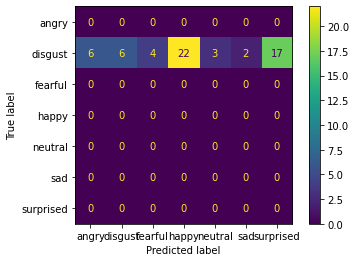

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_names)

cm_display.plot()
plt.show()

# predict single file

In [ ]:
def predict_single(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [59]:
s_file = {}
file_p = 'data/DC_h05.wav'
emoss = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

speech_array, sampling_rate = torchaudio.load(file_p)
speech_array = speech_array.squeeze().numpy()
speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

s_file["speech"] = speech_array


# prediction

features = processor(s_file["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

input_values = features.input_values.to(device)
attention_mask = features.attention_mask.to(device)

with torch.no_grad():
    logits = model(input_values, attention_mask=attention_mask).logits 

pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()

probabilities = dict(zip(['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'], logits[0].tolist()))

print(probabilities)

print(pred_ids, emoss[pred_ids[0]])

ipd.Audio(data=np.asarray(speech_array), autoplay=True, rate=16000)




/tmp/ipykernel_33/596157498.py:7: FutureWarning: Pass orig_sr=44100, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)


{'angry': -2.7958898544311523, 'disgust': -2.346885919570923, 'fearful': -1.8226004838943481, 'happy': 4.847748279571533, 'neutral': -2.429360866546631, 'sad': -2.638833522796631, 'surprised': -1.5211248397827148}
[3] happy


In [54]:
{'angry': -3.020695209503174, 'disgust': -1.643651008605957, 'fearful': -2.4617154598236084, 'happy': 3.887249708175659, 'neutral': -1.3634716272354126, 'sad': -2.50482177734375, 'surprised': -1.2229408025741577}
[3]

[3]

# The Pianist

In [1]:
# import zipfile
# with zipfile.ZipFile('0001.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/thepianist')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [11]:


class Wav2Vec2ClassificationHead(nn.Module):
    def __init__(self, config):        
        super().__init__()
        self.config = config
        self.relu=nn.ReLU()
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.relu(x)
        x = self.out_proj(x)
        return x

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [12]:
# from dataclasses import dataclass
# from typing import Optional, Tuple
# import torch
# from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [13]:
validation_model_name_or_path = "ravdess-tess-model-trained-2/"
config = AutoConfig.from_pretrained(validation_model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(validation_model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(validation_model_name_or_path).to(device)

In [14]:
def predict_single(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [15]:

import os


for file in glob.glob("data/thepianist/*.wav"):
  # get the base name of the audio file
  basename = os.path.basename(file)
  # get the emotion label
  cmd_str = f"ffmpeg -y -i {file} -ac 1 -ar 16000 'data/thepianist/sampled/{basename}'"
  os.system(cmd_str)


# for file in glob.glob(file_p):
#     pac.convert_wav_to_16bit_mono(file, file)
    
    
# torchaudio.load('data/thepianist/sampled/0002.wav')


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [16]:

angry_data = []
disgust_data = []
fearful_data = []
happy_data = []
neutral_data = []
sad_data = []
surprised_data = []

angry_gen = 0
disgust_gen = 0
fearful_gen = 0
happy_gen = 0
neutral_gen = 0
sad_gen = 0
surprised_gen = 0

time_data = []

counter = 1;

s_file = {}

for file_p in glob.glob("data/thepianist/sampled/*.wav"):
    emoss = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

    speech_array, sampling_rate = torchaudio.load(file_p)
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    s_file["speech"] = speech_array


    # prediction

    features = processor(s_file["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()

    probabilities = dict(zip(['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'], logits[0].tolist()))

    
    time_data.append(counter)
    counter = counter + 1
    
    angry_data.append(probabilities['angry'] if (probabilities['angry'] > 0.0) else 0.0)
    disgust_data.append(probabilities['disgust'] if (probabilities['disgust'] > 0.0) else 0.0)
    fearful_data.append(probabilities['fearful'] if (probabilities['fearful'] > 0.0) else 0.0)
    happy_data.append(probabilities['happy'] if (probabilities['happy'] > 0.0) else 0.0)
    neutral_data.append(probabilities['neutral'] if (probabilities['neutral'] > 0.0) else 0.0)
    sad_data.append(probabilities['sad'] if (probabilities['sad'] > 0.0) else 0.0)
    surprised_data.append(probabilities['surprised'] if (probabilities['surprised'] > 0.0) else 0.0)
    
    # angry_gen = angry_gen + probabilities['angry']
    # disgust_gen = disgust_gen + probabilities['disgust']
    # fearful_gen = fearful_gen + probabilities['fearful']
    # happy_gen = happy_gen + probabilities['happy']
    # neutral_gen = neutral_gen + probabilities['neutral']
    # sad_gen = sad_gen + probabilities['sad']
    # surprised_gen = surprised_gen + probabilities['surprised']
    
    
    angry_gen = angry_gen + (probabilities['angry'] if (probabilities['angry'] > 0.0) else 0.0)
    disgust_gen = disgust_gen + (probabilities['disgust'] if (probabilities['disgust'] > 0.0) else 0.0)
    fearful_gen = fearful_gen + (probabilities['fearful'] if (probabilities['fearful'] > 0.0) else 0.0)
    happy_gen = happy_gen + (probabilities['happy'] if (probabilities['happy'] > 0.0) else 0.0)
    neutral_gen = neutral_gen + (probabilities['neutral'] if (probabilities['neutral'] > 0.0) else 0.0)
    sad_gen = sad_gen + (probabilities['sad'] if (probabilities['sad'] > 0.0) else 0.0)
    surprised_gen = surprised_gen + (probabilities['surprised'] if (probabilities['surprised'] > 0.0) else 0.0)
    
#     print(probabilities)

#     print(pred_ids, emoss[pred_ids[0]])

#     ipd.Audio(data=np.asarray(speech_array), autoplay=True, rate=16000)

print('angry_gen', angry_gen)
print('disgust_gen', disgust_gen)
print('fearful_gen', fearful_gen)
print('happy_gen', happy_gen)
print('neutral_gen', neutral_gen)
print('sad_gen', sad_gen)
print('surprised_gen', surprised_gen)


/tmp/ipykernel_32/3271246166.py:28: FutureWarning: Pass orig_sr=16000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)


angry_gen 436.4980163872242
disgust_gen 111.80072036385536
fearful_gen 853.1959665380418
happy_gen 448.1072100866586
neutral_gen 185.67325398512185
sad_gen 331.00243873894215
surprised_gen 362.0440804362297


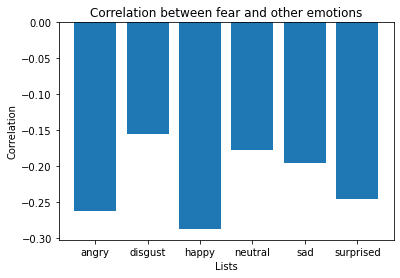

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
x = fearful_data
y1 = angry_data
y2 = disgust_data
y3 = happy_data
y4 = neutral_data
y5 = sad_data
y6 = surprised_data

# Calculate correlations
corr1 = np.corrcoef(x, y1)[0, 1]
corr2 = np.corrcoef(x, y2)[0, 1]
corr3 = np.corrcoef(x, y3)[0, 1]
corr4 = np.corrcoef(x, y4)[0, 1]
corr5 = np.corrcoef(x, y5)[0, 1]
corr6 = np.corrcoef(x, y6)[0, 1]

# Create plot
fig, ax = plt.subplots()
ax.bar(['angry', 'disgust', 'happy', 'neutral', 'sad', 'surprised'], [corr1, corr2, corr3, corr4, corr5, corr6])
ax.set_xlabel('Lists')
ax.set_ylabel('Correlation')
ax.set_title('Correlation between fear and other emotions')
plt.show()


In [38]:
import numpy as np

emos = [
    'angry',
    'disgust',
    'fearful',
    'happy',
    'neutral',
    'sad',
    'surprised'
]


# Example lists
lists = [
    angry_data,
    disgust_data,
    fearful_data,
    happy_data,
    neutral_data,
    sad_data,
    surprised_data
]

# Calculate Pearson correlation coefficient for each pair of lists
corr_matrix = np.corrcoef(lists)

# Sort the correlations in descending order
corr_pairs = [(i, j, corr_matrix[i, j]) for i in range(len(lists)) for j in range(i+1, len(lists))]
corr_pairs.sort(key=lambda x: x[2], reverse=True)

# Print the sorted pairs
for i, j, corr in corr_pairs:
    print(f"{emos[i]} and {emos[j]} have a correlation of {corr:.2f}")

disgust and neutral have a correlation of -0.06
angry and disgust have a correlation of -0.07
disgust and sad have a correlation of -0.08
disgust and surprised have a correlation of -0.08
neutral and sad have a correlation of -0.08
disgust and happy have a correlation of -0.10
angry and neutral have a correlation of -0.11
neutral and surprised have a correlation of -0.11
happy and neutral have a correlation of -0.12
happy and surprised have a correlation of -0.15
angry and sad have a correlation of -0.15
sad and surprised have a correlation of -0.15
disgust and fearful have a correlation of -0.16
angry and surprised have a correlation of -0.17
happy and sad have a correlation of -0.18
fearful and neutral have a correlation of -0.18
fearful and sad have a correlation of -0.20
angry and happy have a correlation of -0.20
fearful and surprised have a correlation of -0.25
angry and fearful have a correlation of -0.26
fearful and happy have a correlation of -0.29


In [35]:
print("surprised_data=", surprised_data)

surprised_data= [3.3645150661468506, 0.0, 4.24362850189209, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1216191053390503, 0.0, 0.0, 3.5032875537872314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5092846751213074, 0.07800273597240448, 0.0, 0.0, 0.0, 0.08815962821245193, 0.0, 0.0, 4.767866611480713, 4.940585613250732, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.553260326385498, 1.4328874349594116, 0.0, 0.0, 0.0, 4.329091548919678, 0.0, 0.0, 0.0, 5.191742420196533, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.37310528755188, 2.0951902866363525, 0.6690100431442261, 0.0, 0.0, 0.0, 0.0, 4.862148284912109, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.189140796661377, 2.7691965103149414, 0.0, 1.8098781108856201, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5335983037948608, 0.0, 0.0, 0.0, 0.0, 0.09930813312530518, 0.0, 0.0, 0.0, 0.0, 5.219395160675049, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4593639373779297, 0.0, 0.0, 0.18798591196537018, 0.0, 0.0, 0.5357750654220581, 0.04183283820748329, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

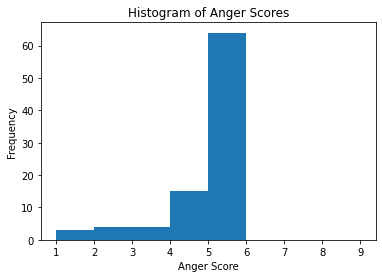

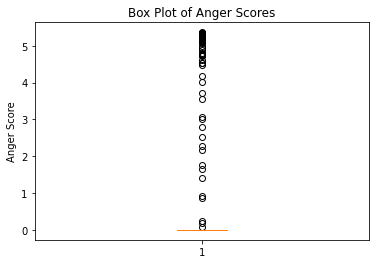

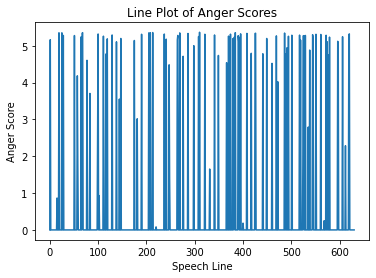

In [17]:
import matplotlib.pyplot as plt

# Sample anger scores for speech lines in a movie
anger_scores = angry_data

# Create a histogram of the anger scores
plt.hist(anger_scores, bins=range(1, 10))
plt.title('Histogram of Anger Scores')
plt.xlabel('Anger Score')
plt.ylabel('Frequency')
plt.show()

# Create a line plot of the anger scores
plt.plot(range(len(anger_scores)), anger_scores)
plt.title('Line Plot of Anger Scores')
plt.xlabel('Speech Line')
plt.ylabel('Anger Score')
plt.show()

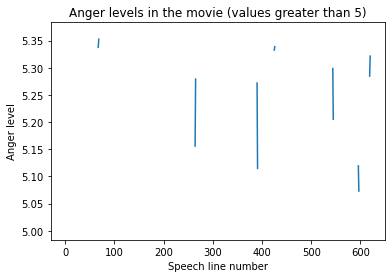

In [21]:
import matplotlib.pyplot as plt

# List of anger values for each speech line
anger = angry_data

# Select only the values of anger greater than 5
anger_levels = [a if a > 5 else None for a in anger]

# Plot the anger levels
plt.plot(anger_levels)

# Add axis labels and title
plt.xlabel('Speech line number')
plt.ylabel('Anger level')
plt.title('Anger levels in the movie (values greater than 5)')

# Show the plot
plt.show()


In [24]:
print('fearful_data=', fearful_data)

fearful_data= [0.0, 0.0, 0.0, 4.888630390167236, 0.0, 5.051147937774658, 0.0, 0.0, 0.0, 0.6783950328826904, 0.0, 4.9057393074035645, 0.0, 0.0, 5.184865951538086, 0.0, 0.0, 0.0, 0.89336758852005, 0.0, 0.0, 2.179586172103882, 3.712376117706299, 5.274547576904297, 0.0, 0.0, 0.0, 5.263834476470947, 0.0, 0.0, 0.0, 5.073201656341553, 0.0, 0.0, 5.326961040496826, 5.2374701499938965, 0.0, 5.20462703704834, 0.0, 0.0, 1.9456311464309692, 5.26200532913208, 4.769652366638184, 0.0, 0.0, 0.0, 5.320390224456787, 0.0, 0.0, 5.122150897979736, 0.0, 0.0, 0.0, 0.0, 1.2520630359649658, 0.8990886807441711, 0.0, 0.0, 0.0, 0.0, 2.70065975189209, 0.0, 5.246712684631348, 0.0, 5.281593322753906, 0.0, 0.0, 0.0, 0.0, 4.889339923858643, 0.0, 0.0, 0.0, 0.6174246668815613, 0.0, 1.4609276056289673, 4.848598957061768, 0.0, 4.49501371383667, 0.0, 0.0, 4.238385200500488, 4.976681232452393, 0.0, 0.0, 0.0, 4.9676432609558105, 0.0, 0.0, 0.0, 0.0, 0.0, 5.235390663146973, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

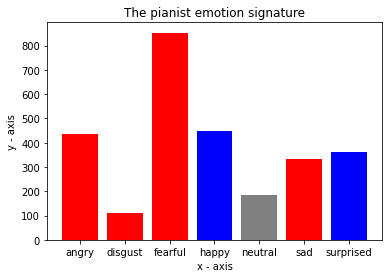

In [103]:
import matplotlib.pyplot as plt
  
# x-coordinates of left sides of bars 
left = [1, 2, 3, 4, 5, 6, 7]
  
# heights of bars
height = [angry_gen, disgust_gen, fearful_gen, happy_gen , neutral_gen, sad_gen, surprised_gen]
  
# labels for bars
tick_label = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'red', 'red', 'blue', 'gray', 'red', 'blue'])
  
# naming the x-axis
plt.xlabel('x - axis')
# naming the y-axis
plt.ylabel('y - axis')
# plot title
plt.title('The pianist emotion signature')
  
# function to show the plot
plt.show()

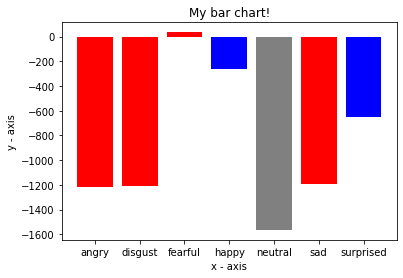

In [99]:

import matplotlib.pyplot as plt
  
# x-coordinates of left sides of bars 
left = [1, 2, 3, 4, 5, 6, 7]
  
# heights of bars
height = [angry_gen, disgust_gen, fearful_gen, happy_gen , neutral_gen, sad_gen, surprised_gen]
  
# labels for bars
tick_label = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'red', 'red', 'blue', 'gray', 'red', 'blue'])
  
# naming the x-axis
plt.xlabel('x - axis')
# naming the y-axis
plt.ylabel('y - axis')
# plot title
plt.title('My bar chart!')
  
# function to show the plot
plt.show()

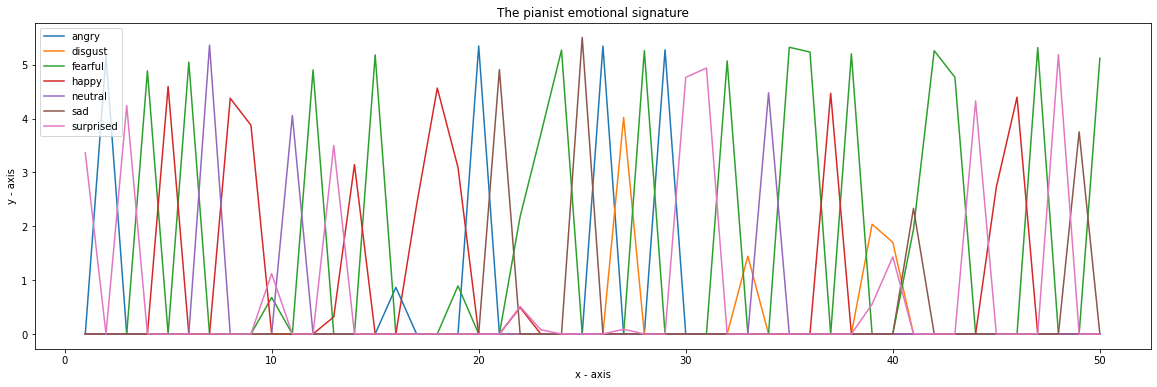

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))

plt.plot(time_data[:50], angry_data[:50], label = "angry")
plt.plot(time_data[:50], disgust_data[:50], label = "disgust")
plt.plot(time_data[:50], fearful_data[:50], label = "fearful")
plt.plot(time_data[:50], happy_data[:50], label = "happy")
plt.plot(time_data[:50], neutral_data[:50], label = "neutral")
plt.plot(time_data[:50], sad_data[:50], label = "sad")
plt.plot(time_data[:50], surprised_data[:50], label = "surprised")
# 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('The pianist emotional signature')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

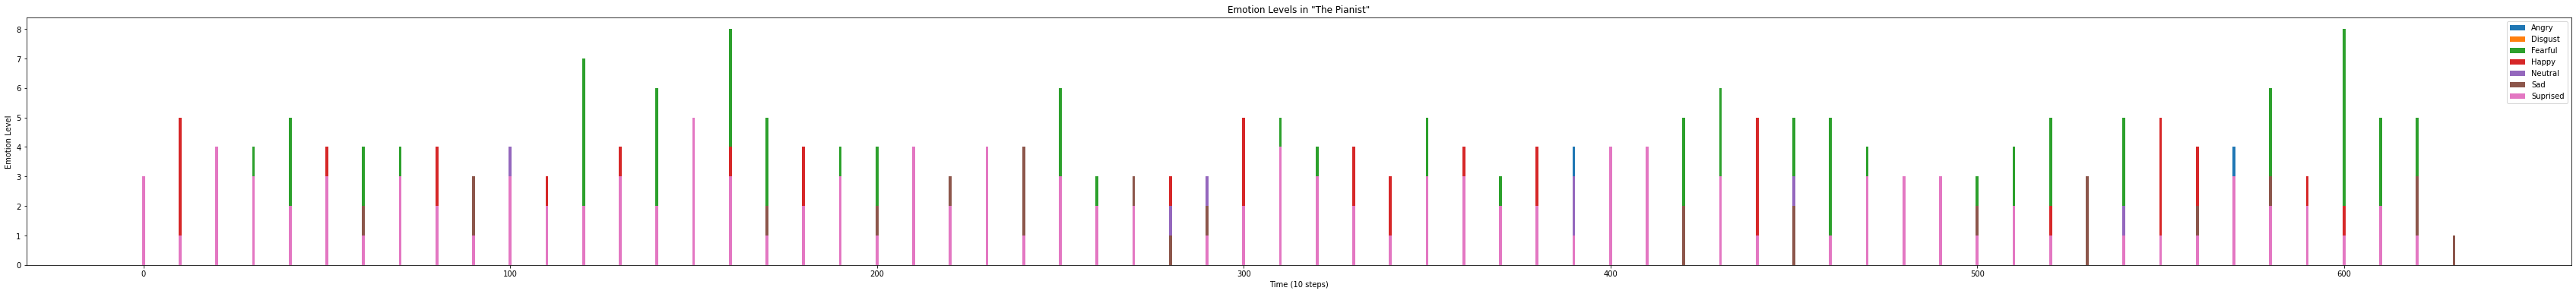

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(60,6))

# Define function to calculate average value for every 10 steps
def avg_by_10(data):
    avg_data = []
    for i in range(0, len(data), 10):
        # avg_data.append(sum(data[i:i+10])/10)
        avg_data.append(len([x for x in data[i:i+10] if x != 0]))
    return avg_data

# Example data
# fearful_data = [0.1, 0.2, 0.3, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.3, 0.4, 0.5, 0.6, 0.5, 0.4, 0.2, 0.1, 0.2, 0.3, 0.4]
# angry_data = [0.4, 0.3, 0.2, 0.1, 0.1, 0.3, 0.4, 0.5, 0.6, 0.5, 0.4, 0.2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.5, 0.4]

# Calculate average value for every 10 steps
angry_avg_data = avg_by_10(angry_data)
disgust_avg_data = avg_by_10(disgust_data)
fearful_avg_data = avg_by_10(fearful_data)
happy_avg_data = avg_by_10(happy_data)
neutral_avg_data = avg_by_10(neutral_data)
sad_avg_data = avg_by_10(sad_data)
surprised_avg_data = avg_by_10(surprised_data)

# Create plot
x_axis = [i*10 for i in range(len(fearful_avg_data))]
plt.bar(x_axis, angry_avg_data, label='Angry')
plt.bar(x_axis, disgust_avg_data, label='Disgust')
plt.bar(x_axis, fearful_avg_data, label='Fearful')
plt.bar(x_axis, happy_avg_data, label='Happy')
plt.bar(x_axis, neutral_avg_data, label='Neutral')
plt.bar(x_axis, sad_avg_data, label='Sad')
plt.bar(x_axis, surprised_avg_data, label='Suprised')

# Add labels and legend
plt.xlabel('Time (10 steps)')
plt.ylabel('Emotion Level')
plt.title('Emotion Levels in "The Pianist"')
plt.legend()

# Show plot
plt.show()


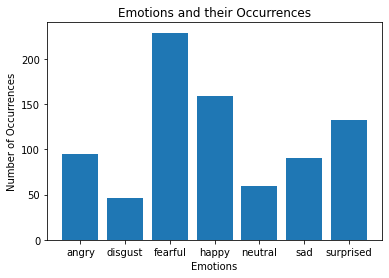

In [29]:
import matplotlib.pyplot as plt

# Define the emotions and their number of occurrences
emotions = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
occurrences = [
    len([x for x in angry_data if x != 0]),
    len([x for x in disgust_data if x != 0]),
    len([x for x in fearful_data if x != 0]),
    len([x for x in happy_data if x != 0]),
    len([x for x in neutral_data if x != 0]),
    len([x for x in sad_data if x != 0]),
    len([x for x in surprised_data if x != 0])]

# Create a bar plot
plt.bar(emotions, occurrences)

# Set the title and labels for the plot
plt.title('Emotions and their Occurrences')
plt.xlabel('Emotions')
plt.ylabel('Number of Occurrences')

# Show the plot
plt.show()


# Onomatopee

In [1]:
# import zipfile
# with zipfile.ZipFile('data/Onomatopee2.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/onomatopee')

In [12]:
!ls data/onomatopee/FEArMP3

In [7]:
import os


for file in glob.glob("data/onomatopee/ACHievementMP3/*.mp3"):
  print(file)
  # get the base name of the audio file
  basename = os.path.basename(file)
  # get the emotion label
  cmd_str = f"ffmpeg -y -i  {file} -acodec pcm_s16le -ac 1 -ar 16000 'data/onomatopee/ACHievementMP3/{basename}'"
  os.system(cmd_str)
